# Event-Driven Simuation
## Luca de Alfaro, 2021


Prepared on: Tue Sep 14 19:41:27 2021

This is a book chapter; it is not a homework assignment.  
Do not submit it as a solution to a homework assignment; you would receive no credit.


In this chapter, we develop a discrete-event simulator, and we use it to simulate a systems in which people interact with workers. 

As an example of system we want to simulate, consider the process of paying at a supermarket. 
The _events_ of the simulator will correspond to things such as a customer joining the check-out queue, a cachier starting ringing up a customer, a cachier finishing ringing up a customer, and so forth. 

In supermarkets with multiple cachiers, the queues for checking-out can be set up in a number of ways.  In one setup, there are separate queues for each cachier, and customers choose which queue to join.  In another setup, there is a single queue, and cachiers, when they are done with a customers, call the next person in line. 

 A simulator enables us to measure the customer servicing times, and to compare alternative "architectures", such as using a single shared queue vs. multiple queues. 

We will first develop a discrete-event simulator, and give a simple example of how to use it.  Then, we move on to the topic of modeling customer-queue-worker systems. 

Before we dive in, let us import a few standard modules we will need. 

In [61]:
from collections import deque # Used to implement queues.
import random # Random choice, etc.
import string
import heapq # Used in discrete event simulator
import numpy as np # Used for gamma probability distribution, and percentiles.


## The discrete-event simulator

Let us write an extremely simple, yet extremely powerful, discrete-event simulator.  A _discrete-event simulator_ maintains a list of events that will occur at a future point in time.  When an event occurs, it can cause the occurrence of other events in the future: for instance, if an event is _"person enters museum"_, this can cause the event _"person leaves museum"_ later on. 

Discrete-event simulators are useful in simulating many real-world systems, from networks (where the events consist in packet transmissions, routings, and receptions), to highway systems (events correspond to cars entering and exiting road segments), to public health (events can be infections, hospitalizations, etc), and much more. 

We start by defining the `Event` class. 



### Event

An _event_ is an object of class `Event`: it consists in calling an object method, with a list of given arguments. 

For example, imagine you have a class `Worker`, with a method `finish`.  Suppose you have a particular worker `w` (an object of class `Worker`), and you want to say: _"in 3 seconds, w will finish, and get paid 10 dollars"_.
Then you can create the event: 

    Event(w.finish, delay=3, args=[10])

In 3 seconds (or time units), this event will cause the following call:

    w.finish(10, time=...)

The `finish` method will have a signature like:

    def finish(self, dollars, time=None)

where the `time` argument will receive the _absolute_ time at which the event happens, and the argument 10 is passed to the method's argument, in this case, `dollars`. 
This `finish` method must return a list of new events caused by the event being processed. 

Here is the definition of the `Event` class: 

In [62]:
def fmt(x):
    """Formats a number x which can be None, for convenience."""
    return None if x is None else "{:.2f}".format(x)

class Event(object):

    def __init__(self, method, delay=0, args=None, kwargs=None):
        """An event consists in calling a specified method after a delay,
        with a given list of args and kwargs."""
        self.method = method
        self.delay = delay
        self.args = args or []
        self.kwargs = kwargs or {}
        self.time = None # Not known until this is added to the queue.

    def __call__(self, time):
        """This causes the event to happen, returning a list of new events
        as a result. Informs the object of the time of occurrence."""
        return self.method(*self.args, time=time, **self.kwargs)

    def __lt__(self, other):
        return self.time < other.time

    def __repr__(self):
        return "@{}: {} {} {} {} dt={:.2f}".format(
            fmt(self.time),
            self.method.__self__.__class__.__name__,
            self.method.__name__,
            self.args, self.kwargs, self.delay
        )


The following is important to remember: 

* An event has the form `Event(obj.method, delay=..., args=[...], kwargs={...})`. 
* The event is scheduled with the delay specified above. 
* When the event occurs, `obj.method` is called with the arguments `obj.method(*args, time=time, **kwargs)`, where time is the current time. In this way, events are informed of their time of occurrence. 
* The call to `obj.method` must return a list of new events to be scheduled; these events are "consequences" of the original event.  Of course, this list can also be empty. 

We call the methods like `obj.method` above, which correspond to events, _event methods_.  We will often improperly refer to "the event `obj.method`" for an `Event(obj.method, ...)`. 

### Event simulator

The event simulator consists of a queue of events, ordered according to their time of occurrence.  At each step, the simulator takes the next event, executes it, and inserts in the queue any resulting new events. 
The only sophisticated point here is that we are using a [heapq](https://docs.python.org/3/library/heapq.html) for storing the list of future events. The heapq implements a [heap data structure](https://en.wikipedia.org/wiki/Heap_(data_structure)) which enables to efficiently add elements to a bag of elements, and pick the least element (the next occurring event) from the bag. 

In [63]:
class EventSimulator(object):

    def __init__(self, trace=False):
        self.events = []
        self.time = 0 # This is the global time.
        self.trace = trace

    def add_event(self, event):
        """Adds an event to the queue."""
        event.time = self.time + event.delay
        heapq.heappush(self.events, event)

    def step(self):
        """Performs a step of the simulation."""
        if len(self.events) > 0:
            event = heapq.heappop(self.events)
            self.time = event.time
            new_events = event(self.time) or []
            for e in new_events:
                self.add_event(e)
            if self.trace:
                print("Processing:", event)
                print("New events:", new_events)
                print("Future events:", self.events)

    def steps(self, number=None):
        """Performs at most number steps (or infinity, if number is None)
        in the simulation."""
        num_done = 0
        while len(self.events) > 0:
            self.step()
            num_done += 1
            if num_done == number:
                break


### An example of simulation

Here is a simple example, modeling a bus stop.  There are two classes, with one object each: a `Stop` class modeling the station, and a `Bus` class modeling the bus; the objects will be simply `stop` and `bus`.

The `stop` has an event `person_arrives`: that is, there is a method `stop.person_arrives`, and events have the form `Event(stop.person_arrives, ...)`.  When one of these events occurs, the number of people at the stop is incremented by one, and a future `person_arrives` event is scheduled after a random delay. 

The `bus` has an event `arrives` (that is, again, a method `bus.arrives`).  When that event occurs, everybody at the stop climbs on the bus, and a future event `bus.arrives` is scheduled. 
We keep track of the number of passengers that climb into the bus each time, so we can compute their average and standard deviation. This is just a simple example, and it could be made more sophisticated in a number of ways. 

Here is the Stop class. 

In [64]:
class Stop(object):

    def __init__(self):
        self.num_people = 0

    # Event method
    def person_arrives(self, time=None):
        # We increment the number of people.
        self.num_people += 1
        # and we schedule the next arrival.
        return [Event(self.person_arrives, delay=np.random.exponential())]

    def get_everybody(self):
        """Returns the number of people who climbs on the bus, and sets
        the people at the station back to 0."""
        n = self.num_people
        self.num_people = 0
        return n


Note that the method `person_arrives` is an _event method_: it is an event that is triggered by an `Event`, and it returns a list of events. 

A bus is created with a reference to its stop, so that it knows from where to pick up passengers.  Here is the code: 

In [65]:
class Bus(object):

    def __init__(self, stop):
        self.stop = stop
        self.passengers = []

    # Event method
    def arrives(self, time=None):
        self.passengers.append(self.stop.get_everybody())
        return [Event(self.arrives, delay=np.random.gamma(2, 10))]


Let us setup the simulation:

In [66]:
stop = Stop()
bus = Bus(stop)

es = EventSimulator()

# We seed the initial events.
es.add_event(Event(bus.arrives, delay=np.random.gamma(2, 10)))
es.add_event(Event(stop.person_arrives, delay=np.random.exponential()))

# We run 100 steps.
es.steps(number=100)

# And we list how many passengers climbed on the bus each time it stopped.
bus.passengers


[26, 29, 2, 33]

## Modeling Customer-Queue-Worker systems

Here is an example of a simple queue network: 

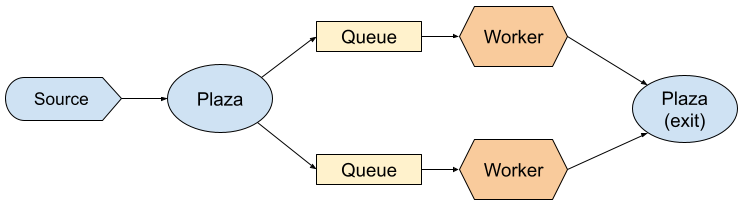

In the network, _plazas_ are places where people can choose where to proceed next; _queues_ allow people to wait for _workers_; a _source_ generates people who enter the system.

For the queue network, we have different types of classes: 

* **Person:** This models a person, traveling across the network. 
* **Worker:** This is a worker (think of a supermarket cachier, or airport check-in attendant) who spends time with a person to do some task. 
* **Queue:** Workers take people from queues.  One queue can feed to only one worker, or many workers can call people from the same queue, as in airport check-ins. 
* **Plazas:** Plazas are places where people are before and after the queue/worker.  In a plaza, people can decide which queue to join next.  A plaza with no queue going out of it is an _exit_: once people reach it, they are done with the system.
* **Source:** Finally, we will have a _source:_ an object which creates people and drops them into the initial plaza.  We can configure the source, changing the rate at which people enter the simulation, as well as the characteristics of the people. 

These classes interact with each other.  In particular: 

* A **person** has only the _finish_ event, triggered when the person enters the exit plaza. 
* A **source** generates events that represent a person entering a plaza. 
* A **plaza** has the _enter_ event (that is, there will be events that correspond to the `enter` method call of a plaza).  When a person enters a plaza, the person chooses which queue to enter next (typically, the shortest). 
* A **queue** event has the _enter_ event.  When a person enters a queue, the worker(s) connected to the queue are notified via the _notify_ event, in case they can begin servicing the person immediately. 
* A **worker** has the above _notify_ event, generated by queues, and also the _finish_ event, signifying that the worker is done helping a person. The worker then checks if the queue contains another person, and if so, starts helping that next person. 

Below, we create the various classes. 

### Person


A person simply stores the start time and end time of the person in the system, so that we can compute how much time elapsed from entry to exit. 

Futhermore, a person stores a _delay shape_ $k$.
Each worker will have a _delay factor_ $\theta$. 
Intuitively, $k$ represents the number of things the person needs to be done (for instance, the number of packages in the cart), and $\theta$ represents the average time the worker takes to do one such thing. 
We assume, in particular, that to do one thing, the worker followsn a memoryless process that lasts an average of $\theta$; the memoryless process corresponds to a [exponential](https://en.wikipedia.org/wiki/Exponential_distribution) time distribution. 
The time it takes to do $k$ memoryless things, each of which takes $\theta$, follows the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) with parameters $k$ and $\theta$, or $\Gamma(k, \theta)$. 
Consequently, 

* The larger $k$ is, the more $\Gamma(k, \theta)$ resembles a gaussian; 
* The average service time is $k\theta$. 

Note that you don't need mastery of these details to follow the code we develop. 
The code of a person does not contain anything particularly interesting, and is provided below. 




In [67]:
class Person(object):

    def __init__(self, start_time=None, num_things=1):
        """Creates a person.
        @param time: time at which person enters the system.
        @param delay_scale: average delay - this is the scale of the gamma
            distribution."""
        self.start_time = start_time # Time of entering the system
        self.end_time = None
        self.num_things = num_things

    # Event method
    def finish(self, time=None):
        """The person has finished the iter through the network."""
        self.end_time = time
        return [] # No events generated as a consequence.

    @property
    def elapsed_time(self):
        return None if self.end_time is None else self.end_time - self.start_time

    def __repr__(self):
        return "Person: D{:.2f} {}-{} elapsed={}".format(
            self.delay_scale,
            fmt(self.start_time), fmt(self.end_time), fmt(self.elapsed_time))


### Source

A _Source_ is in charge of generating people (instances of `Person`), and adding them to the initial plaza. 

The initializer has two parameters. 

The _rate_ of the source is the average number of people that enter, per time unit. 

Further, we assume that a fraction of people have more things to do than the rest: precisely, for a `slow_fraction` of $m$, we assume that $1/m$ people have $m$ times as many things to do than everybody else.

The source has one event, the _start_ event, which generates: 
* The _enter_ event for a person in the plaza; 
* Another _start_ event in the future, if the source needs to generate more people.

Thus, to keep generating people entering the plaza, the source simply schedules a future _start_ event each time it performs _start_. 

In [68]:
class Source(object):
    """Source of people, to put into a plaza."""

    def __init__(self, rate=1, slow_fraction=5, num_things=1, plaza=None, number=None):
        """Creates people at a certain rate.  Puts them into the plaza.
        @param slow_fraction: fraction of slow people.
        @param rate: rate at which people are entering.
        @param plaza: plaza where people enter.
        @param number: how many people to generate; None = infinity.
        """
        self.plaza = plaza
        self.slow_fraction = slow_fraction
        self.rate = rate
        self.number = number
        self.num_things = num_things

    def start(self, time=None):
        """Starts generating people."""
        if self.number == 0:
            return [] # Nothing more to be done.
        num_things = self.num_things
        if np.random.random() < 1 / self.slow_fraction:
            num_things *= self.slow_fraction
        # Creates the person
        person = Person(num_things=num_things, start_time=time)
        enter_event = Event(self.plaza.enter, args=[person])
        # Schedules the next person creation.
        self.number = None if self.number is None else self.number - 1
        dt = np.random.gamma(1, 1/self.rate)
        start_event = Event(self.start, delay=dt)
        return [enter_event, start_event]


### Plaza


A plaza can have multiple queues associated with it, and people can decide which queue to take when they are in the plaza. 

The plaza has one event method, `enter`, which occurs when a person enters the plaza. 
Here is a plaza where people enter the shortest queue: 

In [69]:
class Plaza(object):
    """A plaza is a place where people can decide which queue to join next.
    In a random plaza, people simply choose a random queue."""

    def __init__(self, queues=None):
        """Creates a plaza, with an optional attached set of queues.
        The queues can be left to empty, and registered later."""
        self.queues = queues or [] # Queues attached to the plaza.
        # We keep track of who went through it.
        self.visitors = []

    def register_queue(self, queue):
        if queue not in self.queues:
            self.queues.append(queue)

    # Event method
    def enter(self, person, time=None):
        """When a person enters the plaza, a new event is generated,
        of the person entering the shortest queue.
        We could have also have a "dark plaza" subclass in which the
        person enters a randomly selected queue instead."""
        self.visitors.append(person)
        if len(self.queues) == 0:
            # If there are no queues connected to the plaza,
            # the plaza is an exit.
            person.finish(time=time)
            return [] # No events generated.
        len_queues = [len(q) for q in self.queues]
        shortest = min(len_queues)
        q = random.choice([q for q in self.queues if len(q) == shortest])
        return [Event(q.enter, args=[person])]


### Queue


A queue has a list of people in the queue itself, and a list of workers that service the people in the queue. 

The queue itelf is implemented as a [deque](https://docs.python.org/3/library/collections.html#collections.deque), so that both the operations of joining a queue (appending to the right) and leaving the queue (popping out the leftmost element) are efficient. 

The queue has a method `enter`, which is called when a person enters the queue.  When the event happens (when the method is called), the queue must notify all the workers that a person is available by generating `notify` events.  Of course, workers might already be busy, but the notification allows free workers to start servicing people in the queue without delay. 

In [70]:
class Queue(object):

    def __init__(self):
        """We create a queue.  The workers will be filled in later, by calls
        to register_worker from the workers."""
        self.people = deque()
        self.workers = []

    def register_worker(self, worker):
        """This is called by a worker to connect with the queue."""
        if worker not in self.workers:
            self.workers.append(worker)

    # Event method
    def enter(self, person, time=None):
        """Appends the person to the queue, and alerts all the workers,
        by generating `notify` events for each of them."""
        self.people.append(person)
        # Notifies the workers that now there is someone in the queue.
        new_events = []
        for worker in self.workers:
            new_events.append(Event(worker.notify))
        # These are the notification events.
        return new_events

    def exit(self):
        """Picks a person out of the queue, or None if the
        queue is empty."""
        return self.people.popleft() if len(self.people) > 0 else None

    def __len__(self):
        return len(self.people)

    @property
    def empty(self):
        return len(self.people) == 0


### Worker

A worker has: 

* A queue from which to accept people.
* A plaza where to send people once they are done. 
* A delay factor $\theta$, as explained above. 
* A `busy` flag, to remember whether the worker is servicing a person, or is free. 

The internal method `_get_person_from_queue` checks the queue, and: 

* if it is empty, returns an empty list of events;
* otherwise, picks a person from the queue, and schedules the _finish_ event for that person in the future. 

The `notify` method is triggered by a queue.  If the worker is busy, it does not do anything (it ignores the call, returning the empty set of future events). If the worker is free, the worker uses `_get_person_from_queue` to retrieve a person from the queue, and returns the `finish` event.  

The `finish` method is triggered when the worker finishes helping a person.  The `finish` method returns an _enter_ event for the person into the plaza, and possibly, another _finish_ event for the next person in the queue, obtained again via a call to `_get_person_from_queue`. 

In [71]:
class Worker(object):

    def __init__(self, plaza=None, delay_factor=None, queue=None):
        """Creates a worker, optionally passing to it the queues.
        @param plaza: plaza where one goes after being done with the worker.
        @param delay_shape: shape factor for delay distribution. The scale
            comes from the person.
        @param queue: connected queue.
        """
        # Connects the queue and the worker, ...
        self.queue = queue
        queue.register_worker(self)
        # ... and the worker with the plaza.
        self.plaza = plaza
        self.busy = False # Initially, not serving anyone.
        self.delay_factor = delay_factor

    def _get_person_from_queue(self):
        """Gets a person from the queue, and returns the list of
        events to be scheduled as a consequence (None, if no person
        was in fact present, or the finish event for this worker)."""
        person = self.queue.exit()
        if person is None:
            return []
        self.busy = True
        dt = np.random.gamma(self.delay_factor, scale=person.num_things)
        return [Event(self.finish, delay=dt, args=[person])]

    # Event method
    def notify(self, time=None):
        """The queue is telling the worker that there's some job in it."""
        return [] if self.busy else self._get_person_from_queue()

    # Event method
    def finish(self, person, time=None):
        """A person is done with the worker. The person enters the plaza,
        and a new person, if any is available, is taken from one of the queues."""
        # The person will enter the plaza.
        new_events = [Event(self.plaza.enter, args=[person])]
        # We check if there is someone in line.
        self.busy = False # We change to True if needed.
        if len(self.queue) > 0:
            new_events.extend(self._get_person_from_queue())
        return new_events


## Networks

Before we play with our networks, here is some visualization code for the time people take to traverse the network. 

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def histogram_time(plaza):
    """Given a plaza, plots the histogram of time it took people
    in that plaza to go through the network."""
    points = [p.elapsed_time for p in plaza.visitors]
    plt.hist(points)
    plt.show()

def time90(plaza, q=90):
    """Returns the 90% percentile of the time, so that 90% of people
    complete within that time.  This for any 90% q."""
    return np.percentile([p.elapsed_time for p in plaza.visitors], q)


In [73]:
source_rate = 0.1
num_things = 5
source_number = 10000
num_steps = 200000
source_slow_fraction = 5


### A one-stage network

Let us model a one-stage network.  Customers enter a plaza, and from there, they are serviced by three workers. 
There are two architectures.  In the first one, each worker has its own queue, and customers must choose which queue to join: 

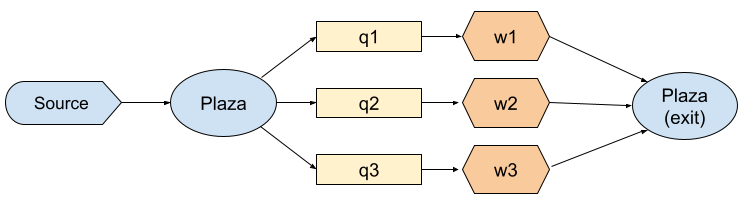

Still in: 0
95% time: 23.14943363284913


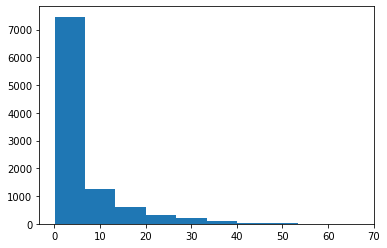

In [74]:
entrance = Plaza()
wayout = Plaza()
s = Source(rate=source_rate, slow_fraction=source_slow_fraction,
           number=source_number, plaza=entrance)

q1 = Queue()
q2 = Queue()
q3 = Queue()
w1 = Worker(delay_factor=2, queue=q1, plaza=wayout)
w2 = Worker(delay_factor=3, queue=q2, plaza=wayout)
w3 = Worker(delay_factor=4, queue=q3, plaza=wayout)

entrance.register_queue(q1)
entrance.register_queue(q2)
entrance.register_queue(q3)

e = Event(s.start)

sim = EventSimulator(trace=False)
sim.add_event(e)
sim.steps(num_steps)

print("Still in:", source_number - len(wayout.visitors))
print("95% time:", time90(wayout, q=95))
histogram_time(wayout)


In another implementation, the three workers share the same queue: 

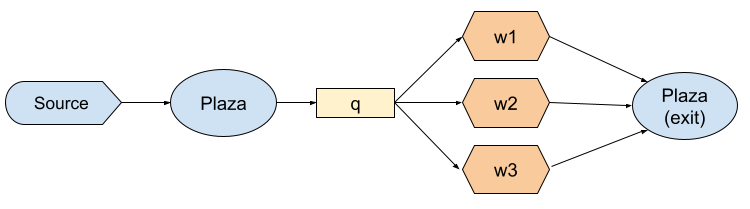

Still in: 0
95% time: 16.20445584790759


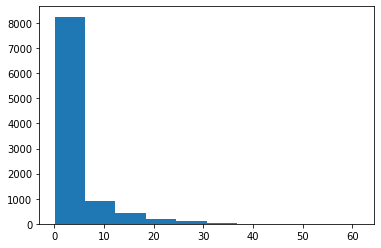

In [75]:
entrance = Plaza()
wayout = Plaza()
q = Queue()
w1 = Worker(delay_factor=2, queue=q, plaza=wayout)
w2 = Worker(delay_factor=3, queue=q, plaza=wayout)
w3 = Worker(delay_factor=4, queue=q, plaza=wayout)
s = Source(rate=source_rate, slow_fraction=source_slow_fraction,
           number=source_number, plaza=entrance)
entrance.register_queue(q)

e = Event(s.start)

sim = EventSimulator(trace=False)
sim.add_event(e)
sim.steps(num_steps)

print("Still in:", source_number - len(wayout.visitors))
print("95% time:", time90(wayout, q=95))
histogram_time(wayout)


You can see that queue sharing reduces the time in which 90% of the customers are helped.  The reason, intuitively, is that it is less likely for customers to become stuck behind slow customers or waiting for slower workers. 

### A two-stage network

We can also simulate two-stage queue networks. 

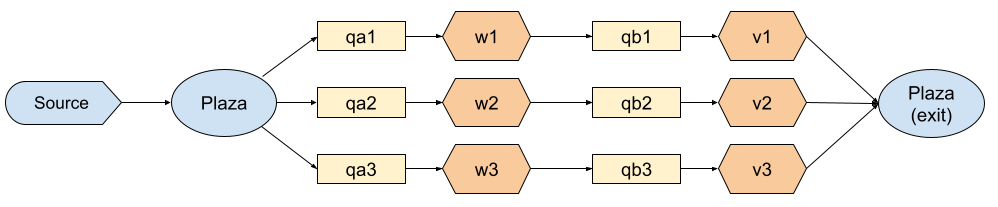

In [76]:
source_rate = 0.1
source_slow_fraction = 10
source_number = 10000
num_steps = 200000


Still in: 0
95% time: 87.5640695156304


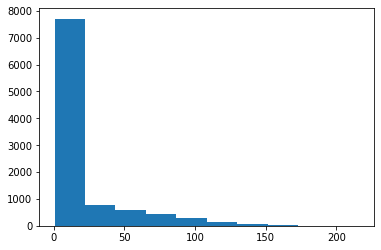

In [77]:
entrance = Plaza()
wayout = Plaza()

# Three intermediate plazas.
pl1 = Plaza()
pl2 = Plaza()
pl3 = Plaza()

# These are queues.
qa1 = Queue()
qa2 = Queue()
qa3 = Queue()
qb1 = Queue()
qb2 = Queue()
qb3 = Queue()

entrance.register_queue(qa1)
entrance.register_queue(qa2)
entrance.register_queue(qa3)
pl1.register_queue(qb1)
pl2.register_queue(qb2)
pl3.register_queue(qb3)

# Workers for the first stage.
w1 = Worker(delay_factor=2, queue=qa1, plaza=pl1)
w2 = Worker(delay_factor=3, queue=qa2, plaza=pl2)
w3 = Worker(delay_factor=4, queue=qa3, plaza=pl3)

# Workers for the second stage.
v1 = Worker(delay_factor=3, queue=qb1, plaza=wayout)
v2 = Worker(delay_factor=4, queue=qb2, plaza=wayout)
v3 = Worker(delay_factor=5, queue=qb3, plaza=wayout)

# Source
s = Source(rate=source_rate, slow_fraction=source_slow_fraction,
           number=source_number, plaza=entrance)

e = Event(s.start)

sim = EventSimulator(trace=False)
sim.add_event(e)
sim.steps(num_steps)

print("Still in:", source_number - len(wayout.visitors))
print("95% time:", time90(wayout, q=95))
histogram_time(wayout)


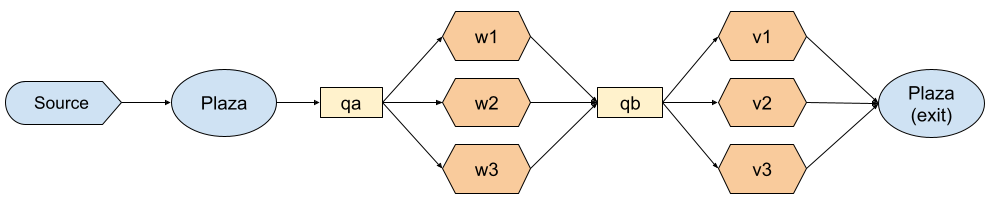

Still in: 0
95% time: 55.25007451105111


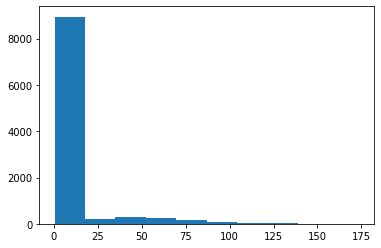

In [78]:
entrance = Plaza()
wayout = Plaza()

# These are the joint queues.
qa = Queue()
qb = Queue()

# One intermediate plaza.
pl = Plaza()

entrance.register_queue(qa)
pl.register_queue(qb)

# Workers for the first stage.
w1 = Worker(delay_factor=2, queue=qa, plaza=pl)
w2 = Worker(delay_factor=3, queue=qa, plaza=pl)
w3 = Worker(delay_factor=4, queue=qa, plaza=pl)

# Workers for the second stage.
v1 = Worker(delay_factor=3, queue=qb, plaza=wayout)
v2 = Worker(delay_factor=4, queue=qb, plaza=wayout)
v3 = Worker(delay_factor=5, queue=qb, plaza=wayout)

# Source
s = Source(rate=source_rate, slow_fraction=source_slow_fraction,
           number=source_number, plaza=entrance)

e = Event(s.start)

sim = EventSimulator(trace=False)
sim.add_event(e)
sim.steps(num_steps)

print("Still in:", source_number - len(wayout.visitors))
print("95% time:", time90(wayout, q=95))
histogram_time(wayout)


We see again how the implementation based on merged queues leads to markedly shorter service times. 